**Лабораторная № 2. Пчелкина Ю.Ж. Сумма элементов вектора**

Задача: реализовать алгоритм сложения элементов вектора
Язык: C++ или Python

Входные данные: Вектор размером 1 000..1 000 000 значений.

Выходные данные: сумма элементов вектора + время вычисления

Реализация должна содержать 2 функции сложения элементов вектора: на CPU и на
GPU с применением CUDA.

Провести эксперименты: получить сумму векторов разных размеров (провести 5 или
более экспериментов), посчитать ускорение. Результаты привести в виде
таблицы/графика.


In [2]:
import math
import random

import numpy as np
from numba import cuda, int32
from tabulate import tabulate

import time
import datetime

import matplotlib.pyplot as plt



Проверим работу функций на примере дного вектора размером 1000

In [4]:
M = 1000
V = np.random.randint(1000, size=M)
#V


#### Сложение всех элементов вектора с использованием служебной функции (на CPU)

In [14]:
# отметили стартовое время
start_time = datetime.datetime.now() 
sum1 = sum(V)
# посчитали затраченное время
t1 = datetime.datetime.now() - start_time
print('сумма элементов вектора = ', sum1)
print ('время обработки: ', str(t1)) 

сумма элементов вектора =  510879
время обработки:  0:00:00.000513


#### Собственная реализация для сложения всех элементов вектора  (на CPU)

In [13]:
def vect_sum_CPU (vect, vect_len):
    s = 0
    for i in range(vect_len):
      s += vect[i]
    return (s)

# отметили стартовое время    
start_time = datetime.datetime.now()    
sum2 = vect_sum_CPU (V, M)
# посчитали затраченное время
t2 = datetime.datetime.now() - start_time

print('сумма элементов вектора = ', sum2)
print ('время обработки: ', str(t2))

сумма элементов вектора =  510879
время обработки:  0:00:00.000362


#### Функция сложения всех элементов вектора (на GPU с применением CUDA)

Вектор делим на части.
Отдельные блоки потоков вычисляют суммы на каждой части.
Затем все суммируем с помощью атомарной функции

In [18]:
# Расчет будет производиться на блоках элементов размером TPB
TPB = 16
# Количество итераций для вычисления среднего затраченного времени
ITER_COUNT = 10

In [19]:
@cuda.jit
def vect_sum_GPU(vec, res):
  shared_v = cuda.shared.array(shape = TPB, dtype=int32)
  # номер нити в блоке
  tx = cuda.threadIdx.x
  # номер блока, в котором находится нить
  bk = cuda.blockIdx.x
  # индекс, под которым работает каждый конкретный поток
  ind = bk*TPB + tx

  shared_v[tx] = 0

  if ind < vec.shape[0]:
    shared_v[tx] = vec[ind]
    if tx == 0:
      sum = 0
      # вычисление в общей памяти
      for i in range (TPB):
        sum += shared_v[i]
      cuda.atomic.add(res, 0, sum)


# список нулевой для записи результатов
R = np.zeros(1, dtype=np.int32)

# отметили стартовое время
start_time = datetime.datetime.now()

d_vec = cuda.to_device(V)
d_res = cuda.to_device(R)
vect_sum_GPU[M, TPB](d_vec, d_res)
sum3 = d_res.copy_to_host()

# посчитали затраченное время
t3 = datetime.datetime.now() - start_time

print('сумма элементов вектора = ', sum3[0])
print ('время обработки: ', str(t3))


сумма элементов вектора =  510879
время обработки:  0:00:00.229791


Все три функции в качестве результата выдают одно и то же значение суммы элементов. 

Для оценки времени работы и ускорения сравниваем три метода : 
- встроенную функцию sum (на CPU), 
- собственную реализацию vect_sum_CPU (на СPU),
- функцию vect_sum_GPU (для расчетов на GPU). 


Для разных размеров векторо (от 1 000  до 1 000 000) проверяем среднее время выполнения для 10 итераций


In [21]:
# для записи результатов
result_list = []

# размер вектора по условию от 1 000 до 1 000 000, 
# расчет производится на блоках элементов TPB = 16
# Количество итераций для вычисления среднего затраченного времени ITER_COUNT = 10

for bpg in range(63, 62500, 100):
  grid_size = bpg
  block_size = TPB
  
  M = bpg * TPB
  
    
  sum_time_sum = 0
  cpu_time_sum = 0
  gpu_time_sum = 0

  for _ in range(ITER_COUNT):
    # создаем ветор размера М
    V = np.random.randint(1000, size=M)
    # создаем нулевой список для записи результатов
    R = np.zeros(1, dtype=np.int32)
    
    # отметили стартовое время
    start = time.time()
    S1 = sum(V)
    # считаем затраченное время
    sum_time = time.time() - start
    sum_time_sum += sum_time

    # отметили стартовое время
    start = time.time()
    S2 = vect_sum_CPU (V, M)
    # считаем затраченное время
    cpu_time = time.time() - start
    cpu_time_sum += cpu_time


    # отметили стартовое время
    start = time.time()
    # Перенос данных в глобальную память GPU
    d_vec = cuda.to_device(V)
    d_res = cuda.to_device(R)
    # вызов ядра
    vect_sum_GPU[M, TPB](d_vec, d_res)
    # Перенос вывода с устройства на хост
    sum3 = d_res.copy_to_host()
    # считаем затраченное время
    gpu_time = time.time() - start
    gpu_time_sum += gpu_time

    

  res = [M, sum_time_sum / ITER_COUNT, cpu_time_sum / ITER_COUNT, gpu_time_sum / ITER_COUNT]
  #print(res)
  result_list.append(res)


In [22]:
print(tabulate(result_list, headers=['matrix size', 'sum time', 'cpu time', 'gpu time']))

  matrix size     sum time     cpu time    gpu time
-------------  -----------  -----------  ----------
         1008  0.00027802   0.000333834  0.0020026
         2608  0.000474644  0.000722909  0.00123074
         4208  0.000751162  0.00112455   0.00132203
         5808  0.00103197   0.00157552   0.0012531
         7408  0.00129211   0.0019871    0.00122476
         9008  0.00161712   0.00243948   0.00130281
        10608  0.00187743   0.00284927   0.00130889
        12208  0.00211926   0.00346003   0.00131829
        13808  0.00249648   0.00371354   0.00133398
        15408  0.00272682   0.00414233   0.00127809
        17008  0.00296185   0.00447125   0.00142927
        18608  0.0033917    0.00497806   0.00168381
        20208  0.00404294   0.00593812   0.00155067
        21808  0.00395105   0.00586472   0.0014262
        23408  0.00425453   0.00721428   0.00145819
        25008  0.00444796   0.00674136   0.0013761
        26608  0.00501482   0.00756814   0.00158169
        28208  0

### Выводы.
 Вычисления на GPU затрачивают меньше времени

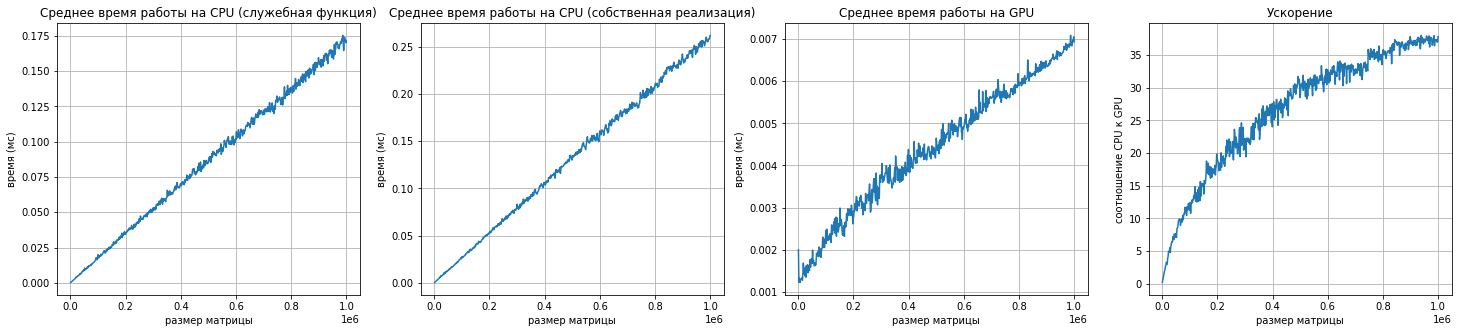

In [23]:
result_matr = np.array(result_list)
plt.figure(figsize=(25, 5))

plt.subplot(1, 4, 1)
plt.title('Среднее время работы на CPU (служебная функция)')
plt.plot(result_matr[:, 0], result_matr[:, 1])
plt.xlabel('размер матрицы')
plt.ylabel('время (мс)')
plt.grid()

plt.subplot(1, 4, 2)
plt.title('Среднее время работы на CPU (собственная реализация)')
plt.plot(result_matr[:, 0], result_matr[:, 2])
plt.xlabel('размер матрицы')
plt.ylabel('время (мс)')
plt.grid()

plt.subplot(1, 4, 3)
plt.title('Среднее время работы на GPU')
plt.plot(result_matr[:, 0], result_matr[:, 3])
plt.xlabel('размер матрицы')
plt.ylabel('время (мс)')
plt.grid()

plt.subplot(1, 4, 4)
plt.title('Ускорение')
plt.plot(result_matr[:, 0], (result_matr[:, 2]/result_matr[:, 3]))
plt.xlabel('размер матрицы')
plt.ylabel('соотношение CPU к GPU')
plt.grid()

